# STA 141B Assignment 2

Due __Jan 29, 2019__ by 11:59pm. Submit by editing this file, committing the changes with git, and then pushing to your private GitHub repo for the assignment. This assignment will be graded for correctness.

Please do not rename this file or delete the exercise cells, because it will interfere with our grading tools. Put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text. Answer all questions with complete sentences.

The purpose of this assignment is to practice using data frames to index, slice, reshape, aggregate, and group data.

## Aquaculture Data Set 🐟🦐

The U.S. Department of Agriculture publishes data sets about U.S. food production online. In the next few exercises, you'll use the [U.S. Aquaculture data set](https://www.ers.usda.gov/webdocs/DataFiles/47759/AquacultureTradeFull.xls?v=661.2). The data set contains information about fish and shellfish imports and exports (more info [here](https://www.ers.usda.gov/data-products/aquaculture-data/)). The data set is published as a single Excel file.

__Exercise 1.5 (20 points).__ Download the aquaculture data set, open it in your favorite spreadsheet program, and take a moment to familiarize yourself with the data.

Use Pandas to _read_ the sheet that contains total imports from the Excel file. Clean the data frame so that it's _tidy_ (more info [here](http://shzhangji.com/blog/2017/09/30/pandas-and-tidy-data/) and [here](https://www.jstatsoft.org/article/view/v059i10)). In particular, make sure that:

* years are in a single column
* measurements are in a single column
* all observations indicate whether they are value or volume
* fish type and preparation are in separate columns
* footnotes are removed

For example, after tidying the data, I ended up with a multiindex series that looked like:

```
measurement     product  format             year
volume_1000lbs  Trout     fresh and frozen  1989    1467.892443
                                            1990    5898.067124
                                            1991    3866.117733
                                            1992    6200.029791
                                            1993    4744.615508
                                            ...
dtype: float64
```

Your result does not have to be identical, but should have a similar shape. Your result can be a data frame with multiple columns, or a multiindex series.

Convert your code into a function `read_aqua_mx()` with appropriate documentation and parameters. Test that your function can also correctly read the total exports sheet.

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#import data
aqua = pd.read_excel("../assignment-2-hushuli/AquacultureTradeFull.xls",sheet_name=1,skiprows = 1)

# delete last 3 row which are footnotes 
aqua = aqua[:-3]

#rename first col and second col as measurement and product
aqua = aqua.rename(columns = {aqua.columns[0]: "Measurement", aqua.columns[1]: "Product"})
aqua.head()

# filled the NAN with the Measurement name
aqua['Measurement'] = aqua['Measurement'].fillna(method = 'ffill')

# Clean the labels on product column
label = aqua['Product'].str.strip("/0123456789").str.partition(',') # remove numbers and seperate with comma

# #split the Product as product and format, and seperate them by the ","
aqua['Product'] = label.iloc[:,0] # rename first col in label as product
aqua['Format'] = label.iloc[:,2] # rename third col in label as format

# set index 
aqua = aqua.set_index(["Measurement","Product",'Format']) # set those three cols as index

# stack to make the year in one column
aqua = aqua.stack()

# after stack, reset index
aqua = aqua.reset_index()
aqua.head()

# change column name to year and Value
aqua = aqua.rename(columns = {0: "V"}) # rename first col as V(Value and Volumn)
aqua.columns.values[[3]] = ["Year"]

# clean up the format col
aqua["Format"] = aqua["Format"].str.strip()
aqua.head()

,Measurement,Product,Format,Year,V
0,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1989,1467.892443
1,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1990,5898.067124
2,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1991,3866.117733
3,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1992,6200.029791
4,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1993,4744.615508


In [39]:
# convert to the function
def read_aqua_mx(csv,page):
    '''This function will return a clearn dataset from the csv gave us'''
    aqua = pd.read_excel(csv,sheet_name=page,skiprows = 1) # import the csv
    aqua = aqua[:-3] # remove last 3 row of data
    aqua = aqua.rename(columns = {aqua.columns[0]: "Measurement", aqua.columns[1]: "Product"}) # rename
    aqua['Measurement'] = aqua['Measurement'].fillna(method = 'ffill') # fill the Nan
    label = aqua['Product'].str.strip("/0123456789").str.partition(',') # claen the row
    aqua['Product'] = label.iloc[:,0] # seperate the label
    aqua['Format'] = label.iloc[:,2] # rename the labels 
    aqua = aqua.set_index(["Measurement","Product",'Format']) # set index
    aqua = aqua.stack() # stack the data
    aqua = aqua.reset_index() # reset index
    aqua = aqua.rename(columns = {0: "V"}) # rename the col 0
    # aqua = aqua.columns.values[[3]] = ["Year"]
    aqua = aqua.rename(columns = {'level_3': "Year"}) # rename to year
    aqua["Format"] = aqua["Format"].str.strip() # clean format col

    return aqua # return a readable dataframe


In [7]:
# use the function to read the cvs 
func = read_aqua_mx("../assignment-2-hushuli/AquacultureTradeFull.xls",1)
func.head()

,Measurement,Product,Format,Year,V
0,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1989,1467.892443
1,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1990,5898.067124
2,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1991,3866.117733
3,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1992,6200.029791
4,"Volume\n(1,000 pounds)",Trout,fresh and frozen,1993,4744.615508


__Exercise 1.6 (20 points).__ What kind of fish or shellfish did the U.S. import the most of in 2017, and how much was imported? What was the total value of the most imported fish or shellfish, and was its value highest across all imports in 2017?

Was the most imported fish or shellfish different in previous years?

In [40]:
# subset the volumn and in 2017
vol17 = aqua.loc[(aqua['Year'] == '2017') & aqua["Measurement"].str.startswith("Vol"),:]

# get index of max volume product 
idx = vol17['V'].idxmax()
vol17.loc[idx,:] # loc the row of max product
## The frpzen shrimp is the most import fish in 2017, and import 1.13962e+06

Measurement    Volume\n(1,000 pounds)
Product                        Shrimp
Format                         frozen
Year                             2017
V                         1.13962e+06
Name: 266, dtype: object

In [41]:
# subset the value and in 2017
val17 = aqua.loc[(aqua['Year'] == '2017') & aqua['Measurement'].str.startswith('Val'),:]

# the value of the shirmp & frozen
value = val17.loc[(val17['Product'] == 'Shrimp') & (val17['Format'] == 'frozen'),:]
# from previous max volue we know the product and format, then looking by using the info to find the most value
value ## the value is 5063378.614

,Measurement,Product,Format,Year,V
567,"Value\n(1,000 U.S. dollars)",Shrimp,frozen,2017,5063378.614


In [42]:
# the frozen shrimp import volumn change over years
Mx_imp = aqua.loc[(aqua['Product'] == 'Shrimp') & (aqua['Format'] == 'frozen') & (aqua["Measurement"].str.startswith("Vol")),:]
# find the data by slice the product, format and mearsurement
Mx_imp = Mx_imp[:-2] #remove last two row which is late 2017
Mx_imp.head() # look at the value

,Measurement,Product,Format,Year,V
238,"Volume\n(1,000 pounds)",Shrimp,frozen,1989,472698.571895
239,"Volume\n(1,000 pounds)",Shrimp,frozen,1990,464542.169360
240,"Volume\n(1,000 pounds)",Shrimp,frozen,1991,499865.961250
241,"Volume\n(1,000 pounds)",Shrimp,frozen,1992,558583.753367
242,"Volume\n(1,000 pounds)",Shrimp,frozen,1993,556215.230949


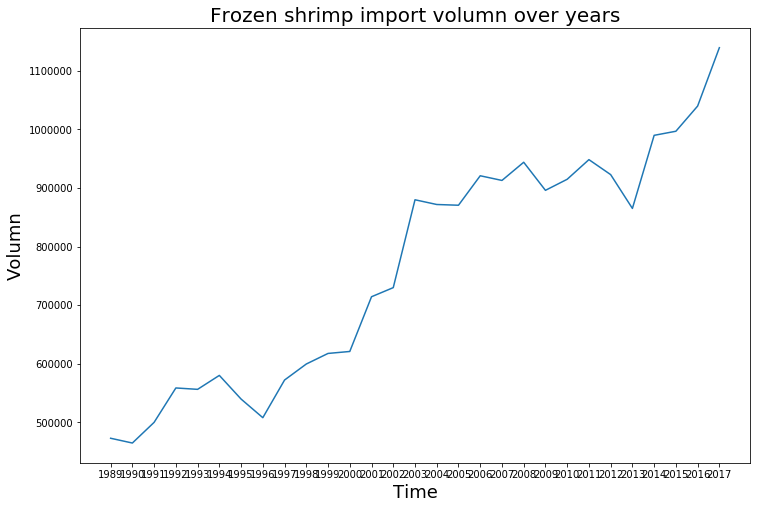

In [43]:
# plot line plot to show how the change of each year in each country of import shrimp
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)

sns.lineplot(data=Mx_imp, x='Year', y='V',ci=None)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Volumn',fontsize=18)
plt.title('Frozen shrimp import volumn over years',fontsize=20)

plt.draw()

__Exercise 1.7 (20 points).__ Repeat the analysis from Exercise 1.6 for exports.

Are there any fish or shellfish that the U.S. imports and also exports?

In [407]:
# function to import the export sheet in csv
exports = read_aqua_mx("../assignment-2-hushuli/AquacultureTradeFull.xls",2)
exports.head()

# max volumn export in all years
maxexp = exports.groupby("Year").apply(get_max_vol_fishs)
maxexp.head()

# find the products that the U.S. imports and also exports
set(aqua["Product"]).intersection(set(exports['Product']))

{'Atlantic salmon',
 'Clams ',
 'Mussels ',
 'Oysters ',
 'Pacific salmon',
 'Salmon',
 'Scallops ',
 'Shrimp',
 'Trout'}

__Exercise 1.8 (20 points).__ What are the top five countries the U.S. imported shrimp from in 2017? _You'll need to read another sheet from the data set for this question._

Use a chart to show how volume imported has changed over the years for all countries that have ever been a top five source of shrimp.

In [445]:
# import the data are the import shirmp
impshirmp = pd.read_excel("../assignment-2-hushuli/AquacultureTradeFull.xls",sheet_name=7,skiprows = 2)

# delete last four row which are footnotes
impshirmp = impshirmp[:-4]
# rename first col and second col
impshirmp = impshirmp.rename(columns = {impshirmp.columns[0]: "Product", impshirmp.columns[1]: "Country Code", impshirmp.columns[2]:"Country Name"})
# fill out the product row
impshirmp['Product'] = impshirmp['Product'].fillna(method = 'ffill')
# set the three col as index
impshirmp = impshirmp.set_index(["Product","Country Code",'Country Name']) 
# stack the data
impshirmp = impshirmp.stack()
# reset index
impshirmp = impshirmp.reset_index()
# remame the columns
impshirmp = impshirmp.rename(columns = {impshirmp.columns[3]:"Year",impshirmp.columns[4]:"Value"})

impshirmp.head()

,Product,Country Code,Country Name,Year,Value
0,Total,5490.0,Thailand,1989,48587.027122
1,Total,5490.0,Thailand,1990,55903.067434
2,Total,5490.0,Thailand,1991,100290.044933
3,Total,5490.0,Thailand,1992,118873.588616
4,Total,5490.0,Thailand,1993,147383.023977


In [455]:
def top_country(year):
    '''This function return the top 5 countries shrimp product export'''
    top = impshirmp.loc[(impshirmp["Year"] == year) & (impshirmp["Product"] == "Total"), :] # subset the year and total value 
    top = top.sort_values("Value").iloc[:-1,:] # sort the value
 
    return list(top.tail(5)["Country Name"]) # return the last 5 countries

top_5 = top_country("2017") # apply function to find the top 5 countries in 2017
top_5

['Vietnam', 'Ecuador', 'Thailand', 'Indonesia', 'India']

In [ ]:
# remove last two row of the date Jan-Oct
year = impshirmp["Year"].unique()[:-2] 

# for loop to finde the top 5 countries in each year
country = []
for i in year:
    country += top_country(i)
    
top_5 = set(country) # get the unique countries

# top 5 countries export shrimp in 2017
top_5 = top_country("2017")
# subset all not in top 5 countries
all_not__top5 = impshirmp.loc[impshirmp["Country Name"].isin(top_5),:]

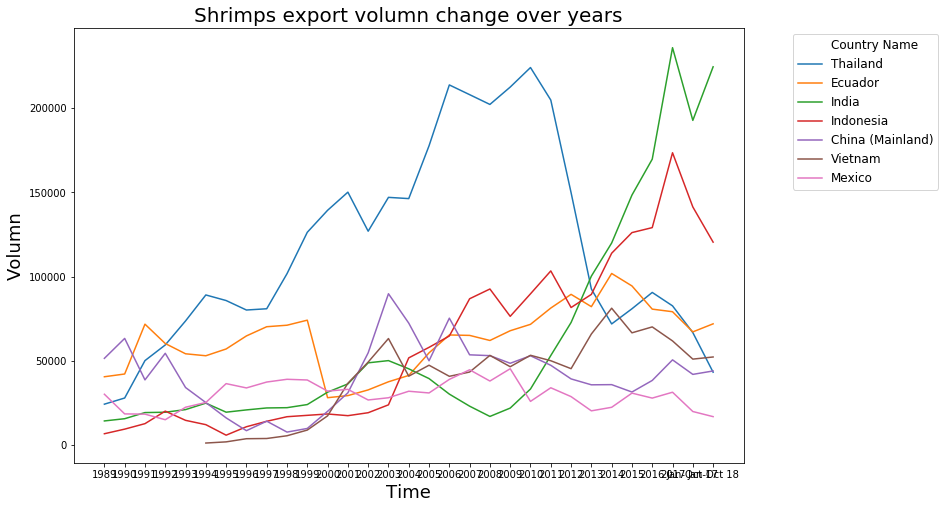

In [453]:
# plot line plot to show how the change of each year in each country of import shrimp
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)

sns.lineplot(data=all_not__top5, x='Year', y='Value', hue='Country Name',ci=None)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Volumn',fontsize=18)
plt.title('Shrimps export volumn change over years',fontsize=20)
legend = plt.legend(bbox_to_anchor=(1.3, 1),prop={'size': 12}) # put legend to the outside of plot
legend.get_title().set_fontsize('12')
plt.draw()